In [1]:
# Cargar las librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

# Cargar la data

In [4]:
# Carga de datos de archivos .csv
url = '/content/drive/MyDrive/Cursos/Coursera/Maestría en Inteligencia Analítica de Datos/202312/Proyecto aplicado en analítica de datos/Proyecto de Grado/datos/SECOP I filtro.txt'
secop1 = pd.read_csv(url, delimiter='|', dtype='str')

# Selecciona las columnas seleccionadas en el preprocesamiento
columnasSeleccionadas = ['UID', #1
                         'Anno Cargue SECOP', #2
                         'Anno Firma Contrato', #3
                         'Nivel Entidad', #4
                         'Orden Entidad', #5
                         'Nombre Entidad', #6
                         'NIT de la Entidad', #7
                         'Código de la Entidad', #8
                         'ID Modalidad', #9
                         'Modalidad de Contratacion', #10
                         'Estado del Proceso', #11
                         'ID Objeto a Contratar', #15
                         'Objeto a Contratar', #16
                         'Detalle del Objeto a Contratar', #17
                         'Municipio de Obtencion', #19
                         'Municipio de Entrega', #20
                         'Numero de Constancia', #23
                         'Numero de Proceso', #24
                         'Numero de Contrato', #25
                         'Cuantia Proceso', #26
                         'ID Grupo', #27
                         'Nombre Grupo', #28
                         'ID Familia', #29
                         'Nombre Familia', #30
                         'ID Clase', #31
                         'Nombre Clase', #32
                         'ID Adjudicacion', #33
                         'Tipo Identifi del Contratista', #34
                         'Identificacion del Contratista', #35
                         'Nom Razon Social Contratista', #36
                         'Dpto y Muni Contratista', #37
                         'Identific Representante Legal', #39
                         'Nombre del Represen Legal', #40
                         'Fecha de Firma del Contrato', #41
                         'Fecha Ini Ejec Contrato', #42
                         'Plazo de Ejec del Contrato', #43
                         'Rango de Ejec del Contrato', #44
                         'Tiempo Adiciones en Dias', #45
                         'Tiempo Adiciones en Meses', #46
                         'Fecha Fin Ejec Contrato', #47
                         'Cuantia Contrato', #49
                         'Valor Total de Adiciones', #50
                         'Valor Contrato con Adiciones', #51
                         'Objeto del Contrato a la Firma', #52
                         'Proponentes Seleccionados', #53
                         'Calificacion Definitiva', #54
                         'Es PostConflicto', #59
                         'Municipio Entidad', #67
                         'Departamento Entidad', #68
                         'Ultima Actualizacion', #69
                         'Fecha Liquidacion', #70
                         'Cumple Decreto 248', #71
                         'IncluyeBienesDecreto248' #72
                         ]


# Imputa valores NA
secop1['Fecha Ini Ejec Contrato'] = secop1['Fecha Ini Ejec Contrato'].fillna(secop1['Fecha de Cargue en el SECOP'])
#secop1['Cuantía Contrato'] = secop1['Cuantía Contrato'].fillna(secop1['Cuantía Proceso'])

# Cambia el tipo de las columnas numericas
columnasNumero = ['Cuantia Proceso', #26
                  'Plazo de Ejec del Contrato', #43
                  'Tiempo Adiciones en Dias', #45 ? sobra
                  'Tiempo Adiciones en Meses', #46 ? sobra
                  'Cuantia Contrato', #49
                  'Valor Total de Adiciones', #50 ? sobra
                  'Valor Contrato con Adiciones'#, #51 ? sobra
                  #'Disciplinarias',
                  #'Contractuales',
                  #'Fiscales',
                  #'PACO'
                  ]
secop1[columnasNumero] = secop1[columnasNumero].astype('int64')

# Convierte a formato fecha
#secop1['Ultima Actualizacion'] = pd.to_datetime(secop1['Ultima Actualizacion'], format='%d/%m/%Y')
secop1['Fecha Ini Ejec Contrato'] = pd.to_datetime(secop1['Fecha Ini Ejec Contrato'], format='%d/%m/%Y')
# Extrae año y mes
secop1['Anno Ini Ejec Contrato'] = secop1['Fecha Ini Ejec Contrato'].dt.year
secop1['Mes Ini Ejec Contrato'] = secop1['Fecha Ini Ejec Contrato'].dt.month

# Convierte años de 0 a 4 segun su posicion en cuetrenios desde 2016
secop1['Anno Ini Ejec Contrato'] = (secop1['Anno Ini Ejec Contrato']-2016)%4


# Crea Prorroga y Adicion
#secop1['Prorroga'] = secop1['Tiempo Adiciones en Dias'].apply(lambda x: 'Prorrogado' if x != 0 else 'No Prorrogado')
secop1['Prorroga'] = secop1['Tiempo Adiciones en Dias'] + secop1['Tiempo Adiciones en Meses']
secop1['Prorroga'] = secop1['Prorroga'].apply(lambda x: 1 if x != 0 else 0)
#secop1['Adicion'] = secop1['Valor Total de Adiciones'].apply(lambda x: 'Adicionado' if x != 0 else 'No Adicionado')
secop1['Adicion'] = secop1['Valor Total de Adiciones'].apply(lambda x: 1 if x != 0 else 0)


# Selecciona las columnas seleccionadas en el feature engineering
columnasSeleccionadas = ['Orden Entidad', #5
                         'Modalidad de Contratacion', #10
                         'Estado del Proceso', #11 adicional
                         #'Nombre Regimen de Contratacion', #14 ? igual que modalidad
                         'Objeto a Contratar', #16
                         'Municipio de Obtencion', #19
                         #'Anno de Cargue en el SECOP', #22 ?
                         #'Mes de Cargue en el SECOP', #22 ?
                         'Cuantia Proceso', #26
                         'Nombre Grupo', #28
                         'Tipo Identifi del Contratista', #34
                         'Identificacion del Contratista', #35 para PACO
                         'Dpto y Muni Contratista', #37
                         'Anno Ini Ejec Contrato', #42
                         'Mes Ini Ejec Contrato', # 42
                         'Plazo de Ejec del Contrato', #43
                         'Rango de Ejec del Contrato', #44
                         'Prorroga', #45 y 46
                         'Tiempo Adiciones en Dias', #45 ? perdida de informacion
                         'Tiempo Adiciones en Meses', #46 ? perdida de informacion
                         'Cuantia Contrato', #49
                         'Adicion', #50
                         'Valor Total de Adiciones', #50 ? sobra
                         'Valor Contrato con Adiciones', #51 ? sobra
                         #'Proponentes Seleccionados', #53
                         'Departamento Entidad' #68
                         ]

secop1 = secop1[columnasSeleccionadas]

# Codificar las columnas categoricas
#secop1['Nivel Entidad'] = pd.factorize(secop1['Nivel Entidad'])[0]
secop1['Orden Entidad'] = secop1['Orden Entidad'].astype('category') #5
#secop1['Orden Entidad'] = pd.factorize(secop1['Orden Entidad'])[0] #5
secop1['Modalidad de Contratacion'] = secop1['Modalidad de Contratacion'].astype('category') #10
#secop1['Modalidad de Contratacion'] = pd.factorize(secop1['Modalidad de Contratacion'])[0] #10
secop1['Estado del Proceso'] = secop1['Estado del Proceso'].astype('category') #11
#secop1['Estado del Proceso'] = pd.factorize(secop1['Estado del Proceso'])[0] #11
secop1['Municipio de Obtencion'] = secop1['Municipio de Obtencion'].astype('category') #11
#secop1['Municipio de Obtencion'] = pd.factorize(secop1['Municipio de Obtencion'])[0] #11
secop1['Nombre Grupo'] = secop1['Nombre Grupo'].astype('category') #28
#secop1['Nombre Grupo'] = pd.factorize(secop1['Nombre Grupo'])[0] #28
secop1['Tipo Identifi del Contratista'] = secop1['Tipo Identifi del Contratista'].astype('category') #34
#secop1['Tipo Identifi del Contratista'] = pd.factorize(secop1['Tipo Identifi del Contratista'])[0] #34
secop1['Dpto y Muni Contratista'] = secop1['Dpto y Muni Contratista'].astype('category') #37
#secop1['Dpto y Muni Contratista'] = pd.factorize(secop1['Dpto y Muni Contratista'])[0] #37
secop1['Rango de Ejec del Contrato'] = secop1['Rango de Ejec del Contrato'].astype('category') #44
#secop1['Rango de Ejec del Contrato'] = pd.factorize(secop1['Rango de Ejec del Contrato'])[0] #44
#secop1['Municipio Entidad'] = pd.factorize(secop1['Municipio Entidad'])[0]
secop1['Departamento Entidad'] = secop1['Departamento Entidad'].astype('category') #68
#secop1['Departamento Entidad'] = pd.factorize(secop1['Departamento Entidad'])[0] #68
#secop1['Prorroga'] = pd.factorize(secop1['Prorroga'])[0]
#secop1['Adicion'] = pd.factorize(secop1['Adicion'])[0]

# Eliminación filas con observaciones nulas
#secop1.dropna(inplace=True)
#secop1.head()

# Convierte los meses a días
secop1.loc[secop1['Rango de Ejec del Contrato'] == 'M', 'Plazo de Ejec del Contrato'] *= 30

# Elimina outliers
secop1 = secop1[secop1['Cuantia Contrato'] < 500_000_000_000]
secop1 = secop1[secop1['Cuantia Contrato'] > 100_000]
secop1 = secop1[secop1['Plazo de Ejec del Contrato'] < 1800] # 5 años
secop1 = secop1[secop1['Plazo de Ejec del Contrato'] > 0]


<ipython-input-4-0d9bfeeccd05>:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secop1['Orden Entidad'] = secop1['Orden Entidad'].astype('category') #5
<ipython-input-4-0d9bfeeccd05>:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secop1['Modalidad de Contratacion'] = secop1['Modalidad de Contratacion'].astype('category') #10


In [5]:
# Carga de datos de archivos PACO .csv
url = '/content/drive/MyDrive/Cursos/Coursera/Maestría en Inteligencia Analítica de Datos/202312/Proyecto aplicado en analítica de datos/Proyecto de Grado/BOTS/Identificacion_resultado.csv'
paco = pd.read_csv(url, delimiter=',')
paco = paco.rename(columns={'Identificacion': 'Identificacion del Contratista'})
paco['Identificacion del Contratista'] = paco['Identificacion del Contratista'].astype('str')

# Crear PACO en 1 cuando tenga alguna sanción
paco['PACO'] = np.where(paco['Disciplinarias'] + paco['Contractuales'] + paco['Fiscales'] > 0, 1, 0)
paco


,Identificacion del Contratista,Disciplinarias,Contractuales,Fiscales,PACO
0,0,0,0,1,1
1,6,0,0,0,0
2,8,0,0,0,0
3,14,0,0,0,0
4,16,0,0,0,0
...,...,...,...,...,...
48518,901193490232,0,0,0,0
48519,901344550672,0,0,0,0
48520,1061759724229,0,0,0,0
48521,1087645645263,0,0,0,0


In [6]:
paco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48523 entries, 0 to 48522
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Identificacion del Contratista  48523 non-null  object
 1   Disciplinarias                  48523 non-null  int64 
 2   Contractuales                   48523 non-null  int64 
 3   Fiscales                        48523 non-null  int64 
 4   PACO                            48523 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.9+ MB


In [7]:
# a secop1 agrega datos de paco
secop1 = pd.merge(secop1, paco, on='Identificacion del Contratista', how='left').fillna(0)
secop1['Disciplinarias'] = secop1['Disciplinarias'].astype('int64')
secop1['Contractuales'] = secop1['Contractuales'].astype('int64')
secop1['Fiscales'] = secop1['Fiscales'].astype('int64')
secop1['PACO'] = secop1['PACO'].astype('int64')

In [8]:
secop1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112367 entries, 0 to 112366
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   Orden Entidad                   112367 non-null  category
 1   Modalidad de Contratacion       112367 non-null  category
 2   Estado del Proceso              112367 non-null  category
 3   Objeto a Contratar              112367 non-null  object  
 4   Municipio de Obtencion          112367 non-null  category
 5   Cuantia Proceso                 112367 non-null  int64   
 6   Nombre Grupo                    112367 non-null  category
 7   Tipo Identifi del Contratista   112367 non-null  category
 8   Identificacion del Contratista  112367 non-null  object  
 9   Dpto y Muni Contratista         112367 non-null  category
 10  Anno Ini Ejec Contrato          112367 non-null  int64   
 11  Mes Ini Ejec Contrato           112367 non-null  int64   
 12  Pl

In [9]:
secop1.describe(include='all')

,Orden Entidad,Modalidad de Contratacion,Estado del Proceso,Objeto a Contratar,Municipio de Obtencion,Cuantia Proceso,Nombre Grupo,Tipo Identifi del Contratista,Identificacion del Contratista,Dpto y Muni Contratista,...,Tiempo Adiciones en Meses,Cuantia Contrato,Adicion,Valor Total de Adiciones,Valor Contrato con Adiciones,Departamento Entidad,Disciplinarias,Contractuales,Fiscales,PACO
count,112367,112367,112367,112367,112367,1.123670e+05,112367,112367,112367,112367,...,112367.000000,1.123670e+05,112367.000000,1.123670e+05,1.123670e+05,112367,112367.000000,112367.000000,112367.000000,112367.000000
unique,13,11,5,56,1027,NaN,7,9,48671,40,...,NaN,NaN,NaN,NaN,NaN,34,NaN,NaN,NaN,NaN
top,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Contratación Mínima Cuantía,Celebrado,"Servicios de Edificación, Construcción de Inst...",No Definido,NaN,[F] Servicios,Nit de Persona Jurídica,900225707,Bogotá D.C.,...,NaN,NaN,NaN,NaN,NaN,Bogotá DC,NaN,NaN,NaN,NaN
freq,48544,36514,58068,64010,16062,NaN,84513,54422,136,13200,...,NaN,NaN,NaN,NaN,NaN,19447,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,7.556751e+08,NaN,NaN,NaN,NaN,...,0.183746,5.989718e+08,0.121441,5.143305e+07,6.504048e+08,NaN,0.001504,0.003489,0.000854,0.004218
std,NaN,NaN,NaN,NaN,NaN,9.203801e+09,NaN,NaN,NaN,NaN,...,1.442529,5.571868e+09,0.326641,1.445467e+09,6.005046e+09,NaN,0.057904,0.073355,0.029520,0.064812
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,...,0.000000,1.003100e+05,0.000000,0.000000e+00,1.003100e+05,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,1.500000e+07,NaN,NaN,NaN,NaN,...,0.000000,1.442659e+07,0.000000,0.000000e+00,1.465396e+07,NaN,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,3.172523e+07,NaN,NaN,NaN,NaN,...,0.000000,3.000000e+07,0.000000,0.000000e+00,3.126336e+07,NaN,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,1.974450e+08,NaN,NaN,NaN,NaN,...,0.000000,1.949810e+08,0.000000,0.000000e+00,1.999990e+08,NaN,0.000000,0.000000,0.000000,0.000000


In [10]:
secop1

,Orden Entidad,Modalidad de Contratacion,Estado del Proceso,Objeto a Contratar,Municipio de Obtencion,Cuantia Proceso,Nombre Grupo,Tipo Identifi del Contratista,Identificacion del Contratista,Dpto y Muni Contratista,...,Tiempo Adiciones en Meses,Cuantia Contrato,Adicion,Valor Total de Adiciones,Valor Contrato con Adiciones,Departamento Entidad,Disciplinarias,Contractuales,Fiscales,PACO
0,NACIONAL DESCENTRALIZADO,Selección Abreviada de Menor Cuantía (Ley 1150...,Liquidado,"Servicios de Edificación, Construcción de Inst...",Cartagena,124957683,[F] Servicios,Nit de Persona Jurídica,900299127,Bolívar,...,0,124957681,0,0,124957681,Bolívar,0,0,0,0
1,DISTRITO CAPITAL,Régimen Especial,Celebrado,"Servicios de Edificación, Construcción de Inst...",Bogotá D.C.,550000,[F] Servicios,Cédula de Ciudadanía,79264272,Bogotá D.C.,...,0,550000,0,0,550000,Bogotá DC,0,0,0,0
2,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,Régimen Especial,Celebrado,"Componentes y Suministros para Estructuras, Ed...",No Definido,129310220,[D] Componentes y Suministros,Nit de Persona Jurídica,900588709,Bolívar,...,0,129310220,1,8022385,137332605,Bolívar,0,0,0,0
3,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,Contratación Directa (Ley 1150 de 2007),Celebrado,"Servicios de Gestion, Servicios Profesionales ...",No Definido,9839815,[F] Servicios,Cédula de Ciudadanía,1128264144,Antioquia,...,0,9839815,0,0,9839815,Antioquia,0,0,0,0
4,TERRITORIAL DEPARTAMENTAL CENTRALIZADO,Régimen Especial,Celebrado,"Servicios de Edificación, Construcción de Inst...",No Definido,274155210,[F] Servicios,Cédula de Ciudadanía,10262853,Caldas,...,0,274155210,0,0,274155210,Caldas,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112362,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,Licitación Pública,Celebrado,"Servicios de Edificación, Construcción de Inst...",Bucaramanga,2969226856,[F] Servicios,Nit de Persona Jurídica,9000591830,Santander,...,0,2969226856,0,0,2969226856,Santander,0,0,0,0
112363,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Contratación Mínima Cuantía,Celebrado,"Servicios de Edificación, Construcción de Inst...",Toledo,20000000,[F] Servicios,Nit de Persona Natural,54572727,Norte De Santander,...,0,19999538,0,0,19999538,Norte De Santander,0,0,0,0
112364,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,Régimen Especial,Liquidado,"Servicios de Edificación, Construcción de Inst...",Fusagasugá,28510000,[F] Servicios,Cédula de Ciudadanía,11300069,Cundinamarca,...,0,28027000,1,2336050,30363050,Cundinamarca,0,0,0,0
112365,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 4,Contratación Mínima Cuantía,Celebrado,"Terrenos, Edificios, Estructuras y Vías",Clemencia,21723395,"[G] Terrenos, Edificios, Estructuras y vías",Nit de Persona Jurídica,900914714,Bolívar,...,0,21723395,0,0,21723395,Bolívar,0,0,0,0


## Visualizar la información

<Axes: xlabel='Departamento Entidad', ylabel='Cuantia Contrato'>

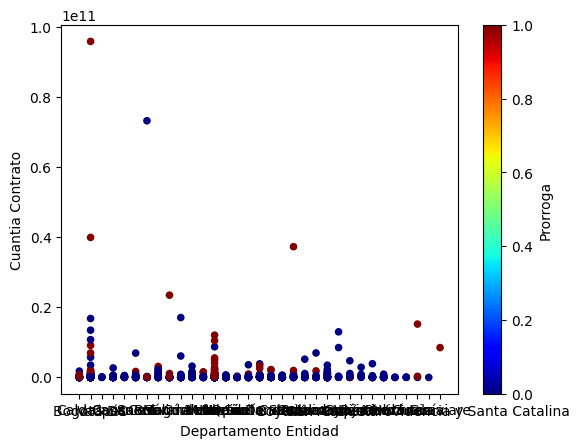

In [11]:
# Gráfica del salario, años y hits
#plt.style.use('fivethirtyeight')
secop1.sample(1000).plot(kind='scatter', x='Departamento Entidad', y='Cuantia Contrato', c='Prorroga', colormap='jet')

<Axes: >

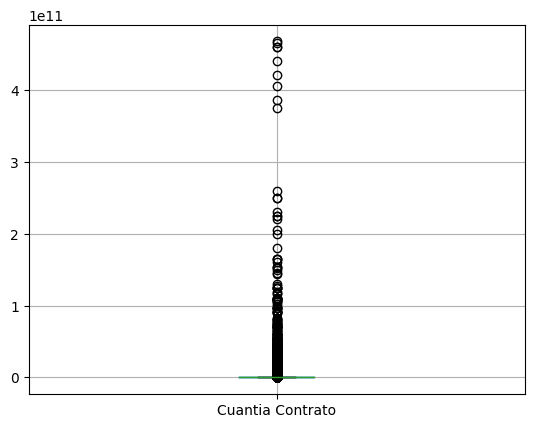

In [12]:
secop1.boxplot(column='Cuantia Contrato')

<Axes: title={'center': 'Plazo de Ejec del Contrato'}, xlabel='Rango de Ejec del Contrato'>

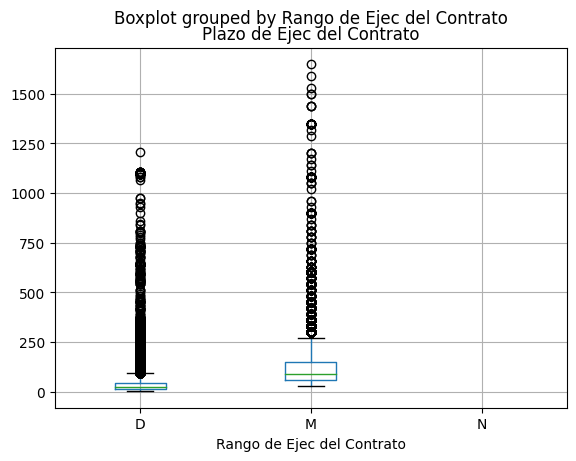

In [13]:
secop1.boxplot(column='Plazo de Ejec del Contrato', by='Rango de Ejec del Contrato')

array([[<Axes: title={'center': 'Cuantia Contrato'}>]], dtype=object)

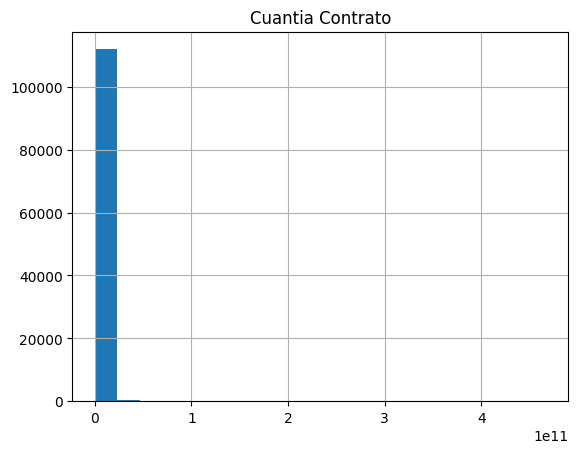

In [14]:
secop1.hist(column='Cuantia Contrato', bins=20)

## Definir las varibles del problema - Predictores y varible de respuesta

In [15]:
# Selección de variables predictoras para Prorroga
feature_cols = ['Orden Entidad', 
                #'Modalidad de Contratacion', #eliminado por baja importancia ?
                #'Estado del Proceso', #eliminado por baja importancia
                #'Objeto a Contratar',
                #'Municipio de Obtencion', #eliminado por baja importancia ?
                #'Cuantia Proceso', #eliminado por baja importancia ?
                #'Nombre Grupo', #eliminado por baja importancia
                #'Tipo Identifi del Contratista', #eliminado por baja importancia
                #'Dpto y Muni Contratista', #eliminado por baja importancia ?
                #'Anno Ini Ejec Contrato', #eliminado por baja importancia ?
                #'Mes Ini Ejec Contrato', #eliminado por baja importancia ?
                'Plazo de Ejec del Contrato',
                #'Rango de Ejec del Contrato', #eliminado por baja importancia
                #'Prorroga',
                #'Tiempo Adiciones en Dias',
                #'Tiempo Adiciones en Meses',
                'Cuantia Contrato', #eliminado por baja importancia ?
                #'Adicion',
                #'Valor Total de Adiciones',
                #'Valor Contrato con Adiciones',
                'Departamento Entidad'
                #'Disciplinarias', #eliminado por baja importancia
                #'Contractuales', #eliminado por baja importancia
                #'Fiscales', #eliminado por baja importancia
                #'PACO' #eliminado por baja importancia
                ]

# Separación de variables predictoras (X) y variable de interes (y)
#secop1sample = secop1.sample(30000) # Se incia con un sample de 20k de los 135k registros
secop1sample = secop1 # Se incia con un sample de 20k de los 135k registros
X = secop1sample[feature_cols]
y = (secop1sample['Prorroga'])

# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40, stratify=y)
print('Train:', y_train.shape[0], '\ny_train:')
print(y_train.value_counts())
print('\nTest:', y_test.shape[0], '\ny_test:')
print(y_test.value_counts())

Train: 75285 
y_train:
0    65505
1     9780
Name: Prorroga, dtype: int64

Test: 37082 
y_test:
0    32265
1     4817
Name: Prorroga, dtype: int64


In [16]:
# Funcion para mostrar los resultados
def mostrar_resultados(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    ConfusionMatrixDisplay(conf_matrix).plot()
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, y_pred))

# Construir un Gradient XGBoost

## Estrategia: Oversampling de la clase minoritaria

### Prorroga

Distribution before resampling Counter({0: 65505, 1: 9780})
Distribution labels after resampling Counter({0: 65505, 1: 65505})
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0.7, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2.5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)


<Figure size 600x600 with 0 Axes>

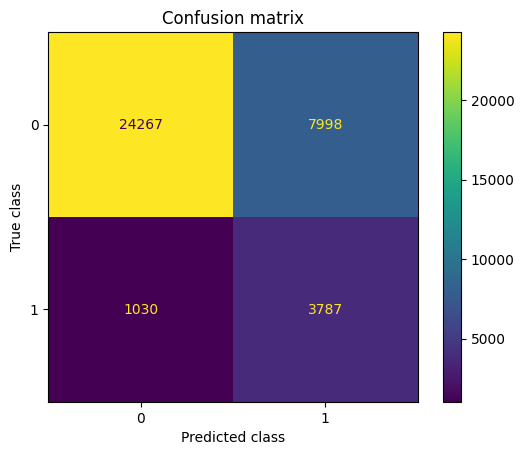

              precision    recall  f1-score   support

           0       0.96      0.75      0.84     32265
           1       0.32      0.79      0.46      4817

    accuracy                           0.76     37082
   macro avg       0.64      0.77      0.65     37082
weighted avg       0.88      0.76      0.79     37082



In [28]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
#clf = XGBClassifier(random_state=1)
clfProrroga = XGBClassifier(tree_method='hist', enable_categorical=True, random_state=1,
                            max_depth=5, min_child_weight=2.5, gamma=0.7, subsample=0.9,
                            colsample_bytree=0.75, reg_alpha=0.01, reg_lambda=0.05,
                            learning_rate=0.3, n_estimators=100)
print(clfProrroga)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clfProrroga.fit(X_train_res, y_train_res)
y_pred = clfProrroga.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

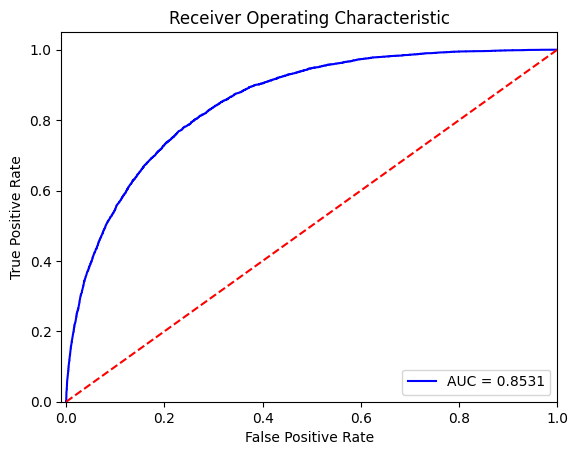

In [29]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clfProrroga.predict_proba(X_test)[:,1], pos_label=clfProrroga.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

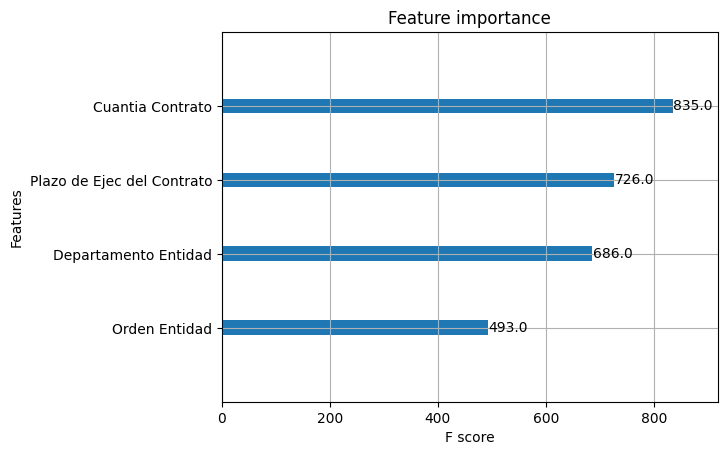

In [30]:
# Importancia de los features
plot_importance(clfProrroga, )

### Adición

In [34]:
# Separación de variables predictoras (X) y variable de interes (y)
#secop1sample = secop1.sample(30000) # Se incia con un sample de 20k de los 135k registros
secop1sample = secop1
X = secop1sample[feature_cols]
y = (secop1sample['Adicion'])

# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40, stratify=y)
print('Train:', y_train.shape[0], '\ny_train:')
print(y_train.value_counts())
print('\nTest:', y_test.shape[0], '\ny_test:')
print(y_test.value_counts())

Train: 75285 
y_train:
0    66142
1     9143
Name: Adicion, dtype: int64

Test: 37082 
y_test:
0    32579
1     4503
Name: Adicion, dtype: int64


Distribution before resampling Counter({0: 66142, 1: 9143})
Distribution labels after resampling Counter({0: 66142, 1: 66142})
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0.7, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2.5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)


<Figure size 600x600 with 0 Axes>

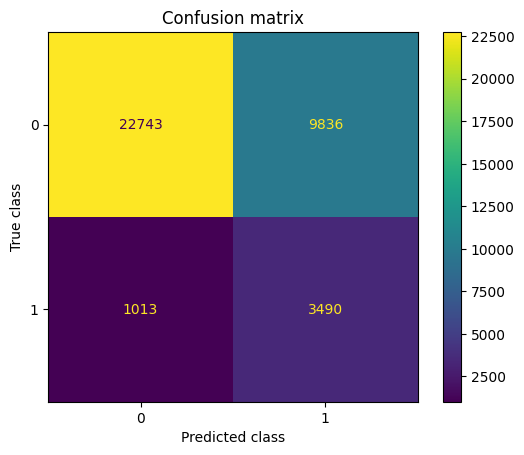

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     32579
           1       0.26      0.78      0.39      4503

    accuracy                           0.71     37082
   macro avg       0.61      0.74      0.60     37082
weighted avg       0.87      0.71      0.76     37082



In [36]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
#clf = XGBClassifier(random_state=1)
clfAdicion = XGBClassifier(tree_method='hist', enable_categorical=True, random_state=1,
                           max_depth=5, min_child_weight=2.5, gamma=0.7, subsample=0.9,
                           colsample_bytree=0.75, reg_alpha=0.01, reg_lambda=0.05,
                           learning_rate=0.3, n_estimators=100) 
print(clfAdicion)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clfAdicion.fit(X_train_res, y_train_res)
y_pred = clfAdicion.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

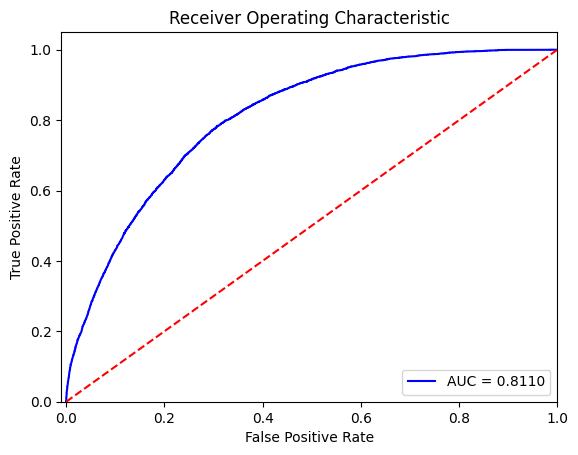

In [37]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clfAdicion.predict_proba(X_test)[:,1], pos_label=clfAdicion.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

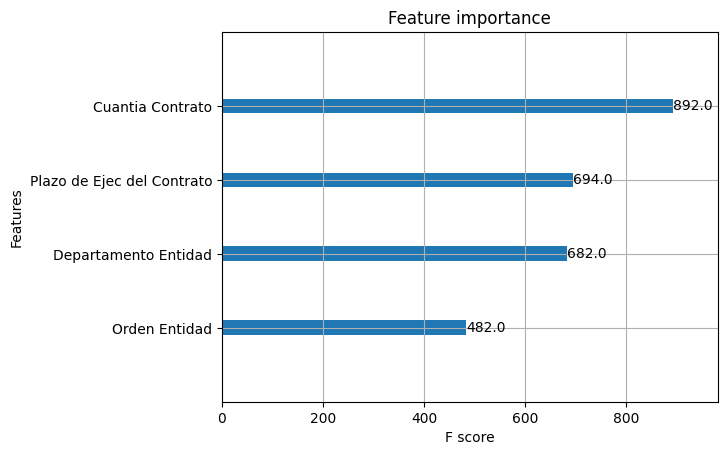

In [38]:
# Importancia de los features
plot_importance(clfAdicion, )

# Encontrar las partes iguales de las variables numéricas

In [39]:
# Dividir Cuantía Contrato en 10 partes iguales
secop1['Cuantia partes'] = pd.qcut(secop1['Cuantia Contrato'], q=20)
secop1.groupby('Cuantia partes')['Cuantia Contrato'].agg(['count', 'min', 'max', 'median'])

,count,min,max,median
Cuantia partes,,,,
"(100309.999, 2679218.5]",5619,100310,2679100,1.500000e+06
"(2679218.5, 5122664.0]",5618,2679495,5122250,3.912768e+06
"(5122664.0, 8070000.0]",5619,5122940,8070000,6.611421e+06
"(8070000.0, 11085300.0]",5618,8072113,11085000,9.769079e+06
"(11085300.0, 14426589.0]",5619,11086500,14426589,1.280803e+07
"(14426589.0, 17112373.8]",5617,14426633,17112333,1.562400e+07
"(17112373.8, 19199975.0]",5620,17112384,19199975,1.853421e+07
"(19199975.0, 20400000.0]",5622,19199998,20400000,1.995000e+07
"(20400000.0, 21878713.5]",5613,20400120,21874776,2.100000e+07


In [40]:
# Genera la lista de las medianas de cada parte de Cuantia
Cuantias = list(secop1.groupby('Cuantia partes')['Cuantia Contrato'].median().values.astype(int))
Cuantias

[1500000,
 3912767,
 6611421,
 9769079,
 12808031,
 15624000,
 18534210,
 19950000,
 21000000,
 23112093,
 37812093,
 54964734,
 82287936,
 114396534,
 161531180,
 227151706,
 367125850,
 610753960,
 1193480204,
 4024162511]

In [41]:
# Dividir Plazo de Ejec del Contrato en 10 partes iguales
secop1['Plazo partes'] = pd.qcut(secop1['Plazo de Ejec del Contrato'], q=10)
secop1.groupby('Plazo partes')['Plazo de Ejec del Contrato'].agg(['count', 'min', 'max', 'median'])

,count,min,max,median
Plazo partes,,,,
"(0.999, 10.0]",14632,1,10,8.0
"(10.0, 15.0]",11101,11,15,15.0
"(15.0, 28.0]",8211,16,28,20.0
"(28.0, 30.0]",20310,29,30,30.0
"(30.0, 45.0]",6671,31,45,45.0
"(45.0, 60.0]",14425,46,60,60.0
"(60.0, 90.0]",12133,61,90,90.0
"(90.0, 120.0]",7273,91,120,120.0
"(120.0, 180.0]",8541,121,180,180.0


In [42]:
# Genera la lista de las medianas de cada parte de Plazo
Plazos = list(secop1.groupby('Plazo partes')['Plazo de Ejec del Contrato'].median().values.astype(int))
Plazos

[8, 15, 20, 30, 45, 60, 90, 120, 180, 270]

In [43]:
# Genera la lista de Orden Entidad
secop1['Orden Entidad'].value_counts()

TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6      48544
TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO    16623
DISTRITO CAPITAL                              7989
TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2       7743
TERRITORIAL DEPARTAMENTAL CENTRALIZADO        5708
NACIONAL DESCENTRALIZADO                      5220
TERRITORIAL DISTRITAL MUNICIPAL NIVEL 5       5152
NACIONAL CENTRALIZADO                         4984
TERRITORIAL DISTRITAL MUNICIPAL NIVEL 4       4798
TERRITORIAL DISTRITAL MUNICIPAL NIVEL 1       4369
TERRITORIAL DISTRITAL MUNICIPAL NIVEL 3       1206
No Definido                                     30
AREA METROPOLITANA                               1
Name: Orden Entidad, dtype: int64

In [44]:
# Genera la lista de Orden Entidad
Entidades = sorted(list(secop1['Orden Entidad'].unique()))
Entidades.remove('No Definido')
Entidades.remove('AREA METROPOLITANA')
Entidades

['DISTRITO CAPITAL',
 'NACIONAL CENTRALIZADO',
 'NACIONAL DESCENTRALIZADO',
 'TERRITORIAL DEPARTAMENTAL CENTRALIZADO',
 'TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO',
 'TERRITORIAL DISTRITAL MUNICIPAL NIVEL 1',
 'TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2',
 'TERRITORIAL DISTRITAL MUNICIPAL NIVEL 3',
 'TERRITORIAL DISTRITAL MUNICIPAL NIVEL 4',
 'TERRITORIAL DISTRITAL MUNICIPAL NIVEL 5',
 'TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6']

In [45]:
# Genera la lista de Departamento Entidad
secop1['Departamento Entidad'].value_counts()

Bogotá DC                                  19447
Antioquia                                  11617
Cundinamarca                                8284
Boyacá                                      7416
Nariño                                      6791
Santander                                   5602
Cauca                                       5193
Valle del Cauca                             4618
Caldas                                      4189
Norte De Santander                          4183
Tolima                                      4148
Bolívar                                     3079
Córdoba                                     2753
Meta                                        2318
Huila                                       2244
Sucre                                       2238
Chocó                                       2159
Magdalena                                   2137
Casanare                                    1786
Cesar                                       1739
Risaralda           

In [46]:
# Genera la lista de Departamento Entidad
Departamentos = sorted(list(secop1['Departamento Entidad'].unique()))
Departamentos.remove('Colombia')
Departamentos

['Amazonas',
 'Antioquia',
 'Arauca',
 'Atlántico',
 'Bogotá DC',
 'Bolívar',
 'Boyacá',
 'Caldas',
 'Caquetá',
 'Casanare',
 'Cauca',
 'Cesar',
 'Chocó',
 'Cundinamarca',
 'Córdoba',
 'Guainía',
 'Guaviare',
 'Huila',
 'La Guajira',
 'Magdalena',
 'Meta',
 'Nariño',
 'Norte De Santander',
 'Putumayo',
 'Quindío',
 'Risaralda',
 'San Andrés Providencia y Santa Catalina',
 'Santander',
 'Sucre',
 'Tolima',
 'Valle del Cauca',
 'Vaupés',
 'Vichada']

# Genera el dataframe a predecir

In [47]:
# Genera el dataframe Predicciones
Predicciones = secop1[['Orden Entidad','Departamento Entidad']].drop_duplicates()
Predicciones = Predicciones[Predicciones['Orden Entidad'].isin(Entidades)]
Predicciones = Predicciones[Predicciones['Departamento Entidad'].isin(Departamentos)]
Predicciones = Predicciones.sort_values(by=['Departamento Entidad', 'Orden Entidad'], ascending=[True, True])
Predicciones = Predicciones.reset_index(drop=True)
Predicciones

,Orden Entidad,Departamento Entidad
0,NACIONAL DESCENTRALIZADO,Amazonas
1,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,Amazonas
2,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2,Amazonas
3,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Amazonas
4,DISTRITO CAPITAL,Antioquia
...,...,...
247,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Vaupés
248,TERRITORIAL DEPARTAMENTAL CENTRALIZADO,Vichada
249,TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,Vichada
250,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 4,Vichada


In [48]:
# Agregar Plazo de Ejec del Contrato
Predicciones['Plazo de Ejec del Contrato'] = pd.Series([Plazos] * len(Predicciones))
Predicciones = Predicciones.explode('Plazo de Ejec del Contrato').reset_index(drop=True)
Predicciones['Plazo de Ejec del Contrato'] = Predicciones['Plazo de Ejec del Contrato'].astype('int64')
Predicciones

,Orden Entidad,Departamento Entidad,Plazo de Ejec del Contrato
0,NACIONAL DESCENTRALIZADO,Amazonas,8
1,NACIONAL DESCENTRALIZADO,Amazonas,15
2,NACIONAL DESCENTRALIZADO,Amazonas,20
3,NACIONAL DESCENTRALIZADO,Amazonas,30
4,NACIONAL DESCENTRALIZADO,Amazonas,45
...,...,...,...
2515,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Vichada,60
2516,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Vichada,90
2517,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Vichada,120
2518,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Vichada,180


In [49]:
# Agregar Cuantia Contrato
Predicciones['Cuantia Contrato'] = pd.Series([Cuantias] * len(Predicciones))
Predicciones = Predicciones.explode('Cuantia Contrato').reset_index(drop=True)
Predicciones['Cuantia Contrato'] = Predicciones['Cuantia Contrato'].astype('int64')
Predicciones

,Orden Entidad,Departamento Entidad,Plazo de Ejec del Contrato,Cuantia Contrato
0,NACIONAL DESCENTRALIZADO,Amazonas,8,1500000
1,NACIONAL DESCENTRALIZADO,Amazonas,8,3912767
2,NACIONAL DESCENTRALIZADO,Amazonas,8,6611421
3,NACIONAL DESCENTRALIZADO,Amazonas,8,9769079
4,NACIONAL DESCENTRALIZADO,Amazonas,8,12808031
...,...,...,...,...
50395,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Vichada,270,227151706
50396,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Vichada,270,367125850
50397,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Vichada,270,610753960
50398,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Vichada,270,1193480204


In [50]:
# Ordena columnas
Predicciones = Predicciones[['Orden Entidad', 'Plazo de Ejec del Contrato', 'Cuantia Contrato', 'Departamento Entidad']]
Predicciones

,Orden Entidad,Plazo de Ejec del Contrato,Cuantia Contrato,Departamento Entidad
0,NACIONAL DESCENTRALIZADO,8,1500000,Amazonas
1,NACIONAL DESCENTRALIZADO,8,3912767,Amazonas
2,NACIONAL DESCENTRALIZADO,8,6611421,Amazonas
3,NACIONAL DESCENTRALIZADO,8,9769079,Amazonas
4,NACIONAL DESCENTRALIZADO,8,12808031,Amazonas
...,...,...,...,...
50395,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,270,227151706,Vichada
50396,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,270,367125850,Vichada
50397,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,270,610753960,Vichada
50398,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,270,1193480204,Vichada


# Genera predicción y descarga archivo

In [51]:
# Genera predicciones
Prorroga = clfProrroga.predict(Predicciones)
Prorroga_proba = clfProrroga.predict_proba(Predicciones)[:,1]
Adicion = clfAdicion.predict(Predicciones)
Adicion_proba = clfAdicion.predict_proba(Predicciones)[:,1]

# Agrega predicciones
Predicciones['Prorroga'] = Prorroga
Predicciones['Prorroga_proba'] = Prorroga_proba
Predicciones['Adicion'] = Adicion
Predicciones['Adicion_proba'] = Adicion_proba
Predicciones

<ipython-input-51-7009adaadbfd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Predicciones['Prorroga'] = Prorroga
<ipython-input-51-7009adaadbfd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Predicciones['Prorroga_proba'] = Prorroga_proba
<ipython-input-51-7009adaadbfd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

,Orden Entidad,Plazo de Ejec del Contrato,Cuantia Contrato,Departamento Entidad,Prorroga,Prorroga_proba,Adicion,Adicion_proba
0,NACIONAL DESCENTRALIZADO,8,1500000,Amazonas,0,0.000180,0,0.000547
1,NACIONAL DESCENTRALIZADO,8,3912767,Amazonas,0,0.001234,0,0.001203
2,NACIONAL DESCENTRALIZADO,8,6611421,Amazonas,0,0.000475,0,0.001464
3,NACIONAL DESCENTRALIZADO,8,9769079,Amazonas,0,0.000440,0,0.006184
4,NACIONAL DESCENTRALIZADO,8,12808031,Amazonas,0,0.001041,0,0.006193
...,...,...,...,...,...,...,...,...
50395,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,270,227151706,Vichada,0,0.030739,0,0.055649
50396,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,270,367125850,Vichada,0,0.030153,0,0.084626
50397,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,270,610753960,Vichada,0,0.093451,0,0.088534
50398,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,270,1193480204,Vichada,0,0.182603,0,0.097738


In [52]:
# Descarga prediccion
Predicciones.to_csv('Predicciones.csv', index=False)